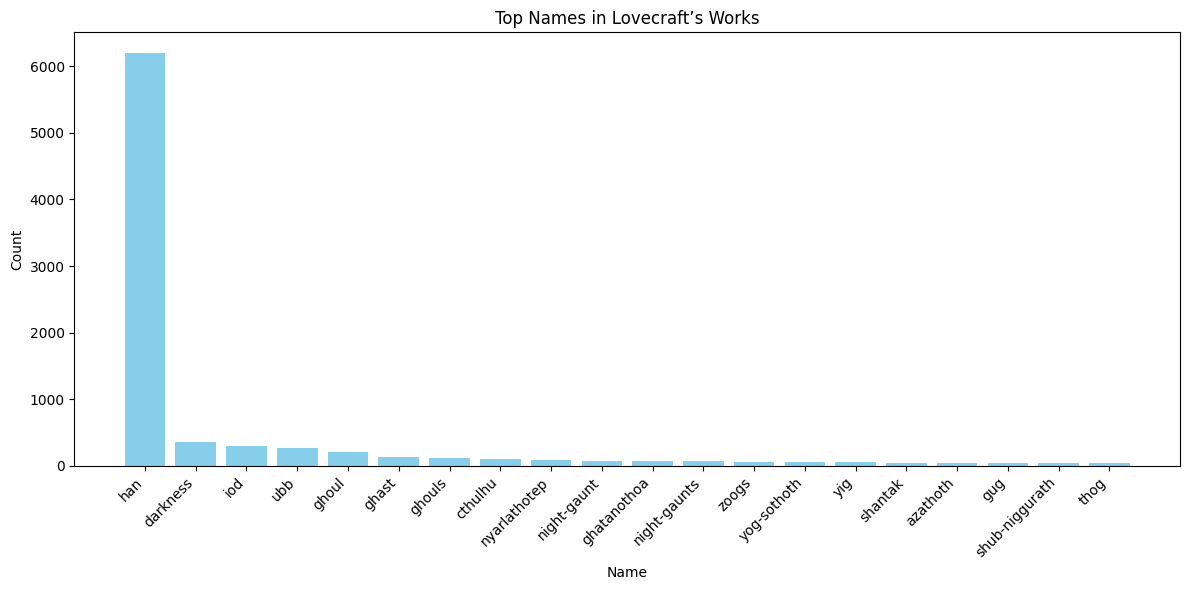

      Token  Frequency
546   could       2322
54      one       2147
626   would       1839
16      old       1444
883    like       1247
50     time       1231
283  seemed       1174
127   great       1110
186     man       1084
35     even       1081
385  though       1045
726    must       1012
401  things        996
148     saw        995
547   found        899
464    came        881
450   night        857
152    long        832
23     upon        801
621   might        798
Final name list created and saved!


In [1]:
import json
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Load JSON files
def load_json(file_path):
    with open(file_path) as f:
        return json.load(f)

creatures = load_json('data/creatures.json')
great_old_ones = load_json('data/great_old_ones.json')
lesser_old_ones = load_json('data/lesser_old_ones.json')
outer_gods = load_json('data/outer_gods.json')
races = load_json('data/races.json')

# Extract names from JSON
def extract_names(data):
    return [item['name'] for item in data]

json_names = (
    extract_names(creatures) +
    extract_names(great_old_ones) +
    extract_names(lesser_old_ones) +
    extract_names(outer_gods) +
    [race['race'] for race in races]
)

# Load and filter Lovecraft data
lovecraft_data = pd.read_csv('data/lovecraft_fiction.csv')

# Filter texts based on names
def filter_texts(data_frame, names):
    return [
        text for text in data_frame['Text'] 
        if any(name.lower() in text.lower() for name in names)
    ]

filtered_texts = filter_texts(lovecraft_data, json_names)

# Count occurrences of names in filtered texts
name_counts = Counter()
for text in filtered_texts:
    for name in json_names:
        name_counts[name] += text.lower().count(name.lower())

# Create DataFrame for name counts
name_counts_df = pd.DataFrame(name_counts.items(), columns=['Name', 'Count'])

# Visualization of name counts
def plot_top_names(name_counts_df, top_n=20):
    top_names = name_counts_df.nlargest(top_n, 'Count')
    plt.figure(figsize=(12, 6))
    plt.bar(top_names['Name'], top_names['Count'], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top Names in Lovecraft’s Works')
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_top_names(name_counts_df)

# Save the name counts to a new CSV file
name_counts_df.to_csv('data_processed/lovecraft_name_counts.csv', index=False)

# Clean text example function
def clean_text(text):
    # Lowercase the text and replace unwanted characters with spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text.lower())  # Replace non-alphanumeric with space
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip()  # Remove leading/trailing whitespace



# Apply cleaning to the 'Text' column
lovecraft_data['Cleaned_Text'] = lovecraft_data['Text'].apply(clean_text)

# Update name counts based on cleaned text
name_occurrences = lovecraft_data['Cleaned_Text'].str.cat(sep=' ').split()
name_count_dict = {name: name_occurrences.count(name.lower()) for name in json_names}
name_counts_df['Updated_Count'] = name_counts_df['Name'].str.lower().map(name_count_dict).fillna(0).astype(int)

# Save updated counts to the data_processed folder
name_counts_df.to_csv('data_processed/updated_lovecraft_name_counts.csv', index=False)

# Prepare stopwords
stop_words = set(stopwords.words('english'))

# Tokenize descriptions and count tokens
def tokenize_descriptions(lovecraft_data):
    entities = []
    for index, row in lovecraft_data.iterrows():
        title = row['Title'].lower()
        text = clean_text(row['Text'])  # Clean the text
        tokens = word_tokenize(text)  # Tokenize the cleaned text
        tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
        sentences = sent_tokenize(text)
        phrases = [phrase for phrase in sentences if len(phrase.split()) > 1]
        entities.append({'name': title, 'description': text, 'tokens': tokens, 'phrases': phrases})
    return pd.DataFrame(entities)



processed_df = tokenize_descriptions(lovecraft_data)
processed_df.to_csv('data_processed/lovecraft_processed_entities.csv', index=False)

# Count token frequencies from all tokens, not just phrases
all_tokens = processed_df['tokens'].explode().tolist()
token_counts = Counter(all_tokens)
token_counts_df = pd.DataFrame(token_counts.items(), columns=['Token', 'Frequency'])
token_counts_df.to_csv('data_processed/lovecraft_token_frequencies.csv', index=False)

# Display the top tokens
sorted_tokens = token_counts_df.sort_values(by='Frequency', ascending=False)
print(sorted_tokens.head(20))

# Extract unique phrases
all_phrases = [phrase for phrases in processed_df['phrases'] for phrase in phrases]
phrase_counts = Counter(all_phrases)
phrase_counts_df = pd.DataFrame(phrase_counts.items(), columns=['Phrase', 'Frequency'])
phrase_counts_df.to_csv('data_processed/lovecraft_phrase_frequencies.csv', index=False)

# Save final name list combining JSON names with filtered text names
combined_names = list(set([name.lower() for name in json_names] + list(token_counts.keys())))
with open('data_processed/final_name_list.txt', 'w') as f:
    for name in combined_names:
        f.write(f"{name}\n")

print("Final name list created and saved!")


In [2]:
# Count occurrences of names
name_occurrences = Counter()
for name in json_names:
    name_occurrences[name] = name_occurrences.get(name, 0) + sum(row['Cleaned_Text'].lower().count(name.lower()) for _, row in lovecraft_data.iterrows())

# Count occurrences of phrases
phrase_occurrences = Counter()
for phrases in processed_df['phrases']:
    phrase_occurrences.update(phrases)

# Create DataFrames for name counts and phrase counts
name_counts_df = pd.DataFrame(name_occurrences.items(), columns=['Name', 'Count'])
phrase_counts_df = pd.DataFrame(phrase_occurrences.items(), columns=['Phrase', 'Frequency'])

# Get top 50 names and phrases
top_names = name_counts_df.nlargest(50, 'Count')
top_phrases = phrase_counts_df.nlargest(50, 'Frequency')

# Print or save the top names and phrases
print("Top 50 Names:")
print(top_names)

print("\nTop 50 Phrases:")
print(top_phrases)

# Optionally, save them to CSV
top_names.to_csv('data_processed/top_50_names.csv', index=False)
top_phrases.to_csv('data_processed/top_50_phrases.csv', index=False)


Top 50 Names:
                                Name  Count
42                               han   6200
20                          darkness    350
49                               iod    296
102                              ubb    274
33                             ghoul    200
30                             ghast    128
141                           ghouls    115
15                           cthulhu     98
68                      nyarlathotep     94
31                       ghatanothoa     68
118                            zoogs     64
114                              yig     51
81                           shantak     43
4                           azathoth     40
41                               gug     40
97                              thog     40
100                       tsathoggua     40
18                             dagon     30
144                             gugs     30
110                              yeb     28
86                          shoggoth     22
70                

In [3]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json


# Load your Lovecraft fiction data
lovecraft_data = pd.read_csv('data/lovecraft_fiction.csv')  # Adjust this if your file has a different name
texts = lovecraft_data['Text'].tolist()  # Replace 'Text' with the correct column name

# Clean the text (define clean_text function if not already done)
def clean_text(text):
    # Implement your cleaning logic here (lowercasing, removing special characters, etc.)
    text = text.lower()
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    return text

# Clean the text data
cleaned_texts = [clean_text(text) for text in texts]

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_texts)
sequences = tokenizer.texts_to_sequences(cleaned_texts)

# Pad sequences
max_length = max(len(seq) for seq in sequences)  # Or set a fixed max length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

# Save padded sequences and tokenizer
np.savetxt('data/padded_sequences.csv', padded_sequences, delimiter=',', fmt='%d')
with open('data/tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)

print("Padded sequences and tokenizer saved!")


Padded sequences and tokenizer saved!


In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import json

# Define tokenizer with specified parameters
# If you are initializing from scratch and training on new data:
# tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
# tokenizer.fit_on_texts(text_data)  # Fit on your actual text data
# Save tokenizer configuration for future reuse:
# tokenizer_json = tokenizer.to_json()
# with open('data/tokenizer.json', 'w') as f:
#     f.write(tokenizer_json)

# Since tokenizer is loaded from saved config, this part loads it as per your setup
with open('data/tokenizer.json') as f:
    tokenizer_json = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_json)

# Define vocabulary size limit to manage the model's size
vocab_size = min(len(tokenizer.word_index) + 1, 10000)

# Load padded sequences
padded_sequences = pd.read_csv('data/padded_sequences.csv').values

# Prepare input (X) and output (y)
X = padded_sequences[:, :-1]  # All but the last token
y = padded_sequences[:, 1:]   # All but the first token

# Ensure y has the appropriate shape for sparse categorical crossentropy
y = y.reshape(-1, y.shape[1])  # (samples, timesteps)

# Define LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=X.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model with sparse categorical crossentropy
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X, y, batch_size=64, epochs=20, validation_split=0.2)

# Save the model
model.save('lovecraft_lstm_model.h5')

print("Model training completed!")


Epoch 1/20


c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Marc Jay\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Marc Jay\AppData\Local\Temp\ipykernel_13716\3707554323.py", line 50, in <module>

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 584, in call

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py", line 140, in call

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\numpy.py", line 5206, in take

  File "c:\Users\Marc Jay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2029, in take

indices[11,47027] = 42599 is not in [0, 10000)
	 [[{{node sequential_1/embedding_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_4488]